In [1]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# general image utils

# get boundary of foreground
def get_boundary(img, axis):
    emp = np.where(np.sum(img, axis=axis) == 0)[0]
    diff = (emp - np.roll(emp, 1))[1:]
    lo = emp[np.where(diff != 1)[0][0]]
    hi = emp[np.where(diff != 1)[0][-1] + 1]
    return lo, hi


# remove all padding around foreground
def remove_padding(img):
    top, bottom = get_boundary(img, 0)
    left, right = get_boundary(img, 1)
    return img[left:right + 1, top:bottom + 1]


# pad image to center given coordinate
def pad_to_center_coord(img, x_c, y_c):
    h, w = img.shape
    
    pad_width = [
        (int(max(h - y_c * 2, 0)), int(max(y_c * 2 - h, 0))),
        (int(max(w - x_c * 2, 0)), int(max(x_c * 2 - w, 0)))
    ]
    
    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img

In [3]:
# moment utils

def get_centroid(img):
    
    h, w = img.shape

    m00 = img.sum()

    y = np.repeat(np.expand_dims(np.array(range(h)), 1), w, 1)
    m01 = np.multiply(y, img).sum()

    x = np.repeat(np.expand_dims(np.array(range(w)), 0), h, 0)
    m10 = np.multiply(x, img).sum()

    x_c = int(m10 // m00)
    y_c = int(m01 // m00)

    return x_c, y_c


def get_second_moment(img):
    
    h, w = img.shape
    x_c, y_c = get_centroid(img)
    
    tmp = np.square((np.array(range(h)) - y_c))
    m02 = np.multiply(tmp, img.sum(axis=1)).sum()

    tmp = np.square((np.array(range(w)) - x_c))
    m20 = np.multiply(tmp, img.sum(axis=0)).sum() 
    
    return m02, m20

In [4]:
# aran utils

# get aspect ratio based on aran
def get_aran(img):
    img = remove_padding(img)
    shape = sorted(img.shape)
    r_init = shape[0] / shape[1]
    aran = math.sin(math.pi / 2 * r_init) ** 0.5
    return aran


# pad image based on aran
def pad_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        diff_w += int((aspect_ratio * h - w) // 2)
    elif w / aspect_ratio > h:
        diff_h += int((w / aspect_ratio - h) // 2)

    pad_width = [(diff_h, diff_h), (diff_w, diff_w)]

    img = np.pad(img, pad_width, mode='constant', constant_values=0)
    return img


# resize image based on aran
def resize_to_aspect_ratio(img, aspect_ratio):

    h, w = img.shape

    # make aspect_ratio = target w / h, it was always < 1 before this
    if w > h:
        aspect_ratio = 1 / aspect_ratio

    # two possible shape:
    # a = (h, aspect_ratio * h)
    # b = (w / aspect_ratio, w)
    diff_h, diff_w = 0, 0
    if aspect_ratio * h > w:
        img = cv2.resize(img, (h, int(aspect_ratio * h // 2 * 2)))
    elif w / aspect_ratio > h:
        img = cv2.resize(img, (int((w / aspect_ratio - h) // 2 & 2), w))

    return img

In [11]:
# interpolation utils

def interpolate_bilinear(x, y, img=None, imgs=None):
    
    if img is not None:
        h, w = img.shape
        img = np.concatenate([img, np.zeros((h, 1))], axis=1)
        img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)
        h, w = img.shape

    vals = []
    for is_x_right in [0, 1]:
        for is_y_right in [0, 1]:
            
            if imgs is not None:
                img = imgs[is_x_right][is_y_right]
                h, w = img.shape
                img = np.concatenate([img, np.zeros((h, 1))], axis=1)
                img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)
                h, w = img.shape
            
            if not is_x_right:
                x_weight = 1 - (np.array(x) % 1)
                x_coords = np.floor(x).astype(int)
            else:
                x_weight = np.array(x) % 1
                x_coords = np.ceil(x).astype(int)
            if not is_y_right:
                y_weight = 1 - (np.array(y) % 1)
                y_coords = np.floor(y).astype(int)
            else:
                y_weight = np.array(y) % 1
                y_coords = np.ceil(y).astype(int)


            tmp1, tmp2 = np.meshgrid(x_weight, y_weight)
            tmp = np.vstack([tmp1.ravel(), tmp2.ravel()]).reshape((2, len(y), len(x)))

            subval = img[y_coords, :]
            subval = subval[:, x_coords]
            tmp = np.concatenate([tmp, np.expand_dims(subval, 0)], axis=0)

            vals.append(tmp.prod(axis=0))

    retval = np.array(vals).sum(axis=0)
    return retval

In [5]:
# MN utils

# find scaling and new boundary
def get_scaling(img, alpha):
    
    m02, m20 = get_second_moment(img)
    delta_y = alpha * m02 ** 0.5
    delta_x = alpha * m20 ** 0.5
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_y_half = int(delta_y // 2)
    delta_x_half = int(delta_x // 2)
    bound_x = (x_c - delta_x_half, x_c + delta_x_half)
    bound_y = (y_c - delta_y_half, y_c + delta_y_half)
    
    return delta_x, delta_y, bound_x, bound_y



In [19]:
# normalization utils

def moment_normalization(img, alpha=4):

    # move centroid to center
    x_c_init, y_c_init = get_centroid(img)
    img = pad_to_center_coord(img, x_c_init, y_c_init)

    # resize based on aran
    img = resize_to_aspect_ratio(img, get_aran(img))

    h, w = img.shape
    y_c = h // 2
    x_c = w // 2

    delta_x, delta_y, bound_x, bound_y = get_scaling(img, alpha=alpha)

    # coordinate mapping
    x = np.array(range(bound_x[0], bound_x[1]))
    y = np.array(range(bound_y[0], bound_y[1]))
    x_mapped = (x - x_c_init) * w / delta_x + x_c
    y_mapped = (y - y_c_init) * h / delta_y + y_c

    # img ---coord_mapping---> img_mapped ---downsample---> img_scaled

    # coordinates after downsampling
    y_scaled = [i * y_mapped.shape[0] / (h) for i in range(h)]
    x_scaled = [i * x_mapped.shape[0] / (w) for i in range(w)]

    # get required coordinates in img_mapped for downsampling
    x_scaled_floor = np.floor(x_scaled).astype(int)
    x_scaled_ceil = np.ceil(x_scaled).astype(int)
    y_scaled_floor = np.floor(y_scaled).astype(int)
    y_scaled_ceil = np.ceil(y_scaled).astype(int)

    # get required coordinates in img_mapped for downsampling and interpolation
    x_mapped_a = x_mapped[x_scaled_floor]
    x_mapped_b = x_mapped[x_scaled_ceil]
    y_mapped_a = y_mapped[y_scaled_floor]
    y_mapped_b = y_mapped[y_scaled_ceil]


    # update x_scaled, y_scaled to be relative to the mapped coordinates
    x_scaled = (np.array(x_scaled) % 1) + range(len(x_scaled))
    y_scaled = (np.array(y_scaled) % 1) + range(len(y_scaled))

    # interpolate required coordinates in the scaled image
    imgs_scaled = [
        [interpolate_bilinear(x_mapped_a, y_mapped_a, img), 
         interpolate_bilinear(x_mapped_a, y_mapped_b, img)],
        [interpolate_bilinear(x_mapped_b, y_mapped_a, img), 
         interpolate_bilinear(x_mapped_b, y_mapped_b, img)]
    ]
    img = interpolate_bilinear(x_scaled, y_scaled, imgs=imgs_scaled)
    img = (img > 0.5).astype(int)

    return img

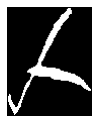

In [20]:
# img_init = cv2.imread('../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png')[:, :, 0]
img_init = cv2.imread('../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png')[:, :, 0]
img_init = remove_padding(img_init)
plt.figure(figsize=(2, 2))
plt.axis("off")
_ = plt.imshow(img_init, 'gray')

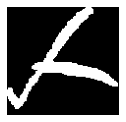

In [22]:
img_mn = moment_normalization(img_init, alpha=4)
plt.figure(figsize=(2, 2))
plt.axis("off")
_ = plt.imshow(img_mn, 'gray')